In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('skyeng_day2.csv')

In [4]:
df1, df2 = train_test_split(df, test_size = 0.5)

In [21]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика - тут ARPU
    bootstrap_conf_level = 0.95 # уровень значимости
):

    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/10000 [00:00<?, ?it/s]

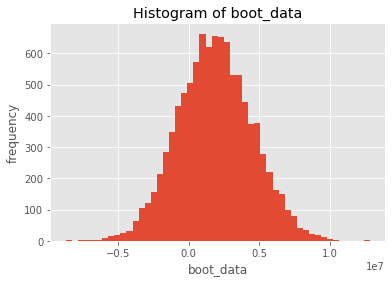

In [22]:
bootstrap_results = get_bootstrap(df1, df2)

Разница средних распределена симметрично, колоколообразно, дальше смотрим что там с p-value

  0%|          | 0/10000 [00:00<?, ?it/s]

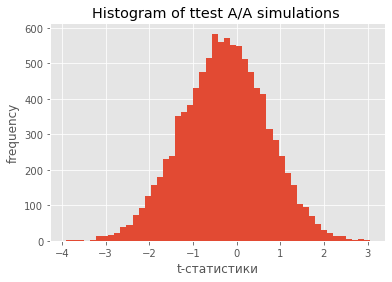

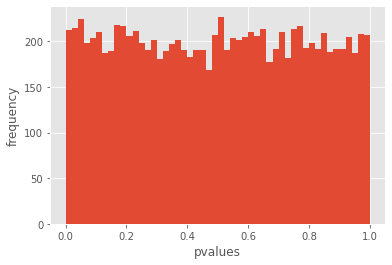

0.0531

In [20]:
simulations = 10000
n_s = 1000
res1 = []
res2 = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df1.check.sample(n_s, replace = False).values
    s2 = df2.check.sample(n_s, replace = False).values
    res1.append(stats.ttest_ind(s1, s2, equal_var = False)[0]) # сохраняем t-статистику
    res2.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res1, bins = 50)
plt.style.use('ggplot')
plt.xlabel('t-статистики')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

plt.hist(res2, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res2) <0.05) / simulations

T-статистика распределена симметрично и колоколообразно, p-value - равномерно. FPR чуть-чуть выше 0.05, но не принципиально  
Вывод - критерий Стьюдента применять можно